In [1]:
"""
Created on Wed Aug  4 17:50:06 2021

@author: amol
"""

# set TF GPU memory growth so that it doesn't hog everything at once
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from main import *
debug_mode = True  # faster experiments for debugging

# util for getting objects' fields' names
field_names = lambda x: list(vars(x).keys())

In [2]:
#Prepare the DataFrame that will be used downstream
dp = DataPreparer()
dp.createPCAs()
dp.sparsePCAs()
dp.zmixOrthogonalPCAs()
df = dp.getDataframe()

# TODO: add PCA from linear model first
df.to_csv('PCA_data.csv', index=False)

# currently passing dp eventually we want to abstract all the constants into 1 class
dm = DataManager(df, dp)

In [ ]:
'''
1. Run the GP Experiments
'''
import time

start=time.time()
exprExec = run_gp_experiments(dm, debug_mode=debug_mode)
print(f'duration: {time.time()-start}')

In [3]:
'''
2. Run the Simple DNN Experiments
'''

exprExec = run_simple_dnn_experiments(dm, debug_mode=debug_mode)

--Return--
None
> <ipython-input-3-a56ddde18154>(5)<module>()
      2 2. Run the Simple DNN Experiments
      3 '''
      4 
----> 5 import pdb; pdb.set_trace()
      6 exprExec = run_simple_dnn_experiments(dm, debug_mode=debug_mode)

ipdb> c
=================== frameworkincludedtrainexcludedtest ===================
------------------ ZmixCpv ------------------
------------------ 2 ------------------
------------------ executeSingleExperiment ------------------
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
prediction (Functional)      (None, 1)                 1409      
Total params: 1,409
Trainable params: 1,281
Non-trainable params: 128
_________________________________________________________________
training model: 1
training model: 2
self.modelType: S

training model: 2
self.modelType: Simple_DNN dataType: frameworkincludedtrainexcludedtest inputType:ZmixCpv noOfCpv:1 ZmixPresent:Y MAE:5505603996.286824
------------------ ZmixPCA ------------------
------------------ executeSingleExperiment ------------------
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 1)]               0         
_________________________________________________________________
prediction (Functional)      (None, 1)                 1393      
Total params: 1,393
Trainable params: 1,265
Non-trainable params: 128
_________________________________________________________________
training model: 1
training model: 2
self.modelType: Simple_DNN dataType: frameworkincludedtrainexcludedtest inputType:ZmixPCA noOfCpv:1 ZmixPresent:Y MAE:5650613659.216779
------------------ SparsePCA ------------------
------------------ executeSingleExp

training model: 1
training model: 2
self.modelType: Simple_DNN dataType: frameworkincludedtrainexcludedtest inputType:ZmixPCA noOfCpv:1 ZmixPresent:Y MAE:8614993663.233803
------------------ SparsePCA ------------------
------------------ executeSingleExperiment ------------------
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 1)]               0         
_________________________________________________________________
prediction (Functional)      (None, 1)                 1393      
Total params: 1,393
Trainable params: 1,265
Non-trainable params: 128
_________________________________________________________________
training model: 1
training model: 2
self.modelType: Simple_DNN dataType: frameworkincludedtrainexcludedtest inputType:SparsePCA noOfCpv:1 ZmixPresent:N MAE:8565099244.166682
------------------ PurePCA ------------------
--------------

training model: 2
self.modelType: Simple_DNN dataType: frameworkincludedtrainexcludedtest inputType:SparsePCA noOfCpv:1 ZmixPresent:N MAE:5998559323.757202
------------------ PurePCA ------------------
------------------ executeSingleExperiment ------------------
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 1)]               0         
_________________________________________________________________
prediction (Functional)      (None, 1)                 1393      
Total params: 1,393
Trainable params: 1,265
Non-trainable params: 128
_________________________________________________________________
training model: 1
training model: 2
self.modelType: Simple_DNN dataType: frameworkincludedtrainexcludedtest inputType:PurePCA noOfCpv:1 ZmixPresent:N MAE:5998556963.35249
------------------ ZmixAndPurePCA ------------------
------------------ executeSi

training model: 2
self.modelType: Simple_DNN dataType: randomequalflamesplit inputType:SparsePCA noOfCpv:1 ZmixPresent:N MAE:14646035807.858965
------------------ PurePCA ------------------
------------------ executeSingleExperiment ------------------
train_set_keys:  [25034, 15777, 32353, 23782, 2134, 7694, 3217, 9944, 7309, 4849, 21463, 11018, 14989, 10467, 3386, 20390, 5373, 9446, 3949, 3564, 18402, 6944, 30735, 12208, 3752, 14239, 2620]
test_set_keys:  [2758, 2246, 3056, 2364, 13527, 2027, 4376, 2903, 5104, 8974, 16608, 12851, 5656, 6267, 8099, 27738, 4157, 17482, 2489, 5953, 8525, 11598, 19371, 29198, 6597, 26352, 22593, 4606]
train:  [ 3752 11018 12208  3217  2620]
test:  [ 2903 27738  2758 12851 17482]
Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 1)]               0         
_________________________________________________________________

training model: 2
self.modelType: Simple_DNN dataType: randomequalflamesplit inputType:ZmixCpv noOfCpv:1 ZmixPresent:Y MAE:13795443651.397722
------------------ ZmixPCA ------------------
------------------ executeSingleExperiment ------------------
train_set_keys:  [25034, 15777, 32353, 23782, 2134, 7694, 3217, 9944, 7309, 4849, 21463, 11018, 14989, 10467, 3386, 20390, 5373, 9446, 3949, 3564, 18402, 6944, 30735, 12208, 3752, 14239, 2620]
test_set_keys:  [2758, 2246, 3056, 2364, 13527, 2027, 4376, 2903, 5104, 8974, 16608, 12851, 5656, 6267, 8099, 27738, 4157, 17482, 2489, 5953, 8525, 11598, 19371, 29198, 6597, 26352, 22593, 4606]
train:  [ 3752 11018 12208  3217  2620]
test:  [ 2903 27738  2758 12851 17482]
Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 1)]               0         
_________________________________________________________________
p

self.modelType: Simple_DNN dataType: randomequalflamesplit inputType:ZmixAllSpecies noOfCpv:53 ZmixPresent:Y MAE:13031421097.296915
------------------ AllSpecies ------------------
------------------ 53 ------------------
------------------ executeSingleExperiment ------------------
train_set_keys:  [25034, 15777, 32353, 23782, 2134, 7694, 3217, 9944, 7309, 4849, 21463, 11018, 14989, 10467, 3386, 20390, 5373, 9446, 3949, 3564, 18402, 6944, 30735, 12208, 3752, 14239, 2620]
test_set_keys:  [2758, 2246, 3056, 2364, 13527, 2027, 4376, 2903, 5104, 8974, 16608, 12851, 5656, 6267, 8099, 27738, 4157, 17482, 2489, 5953, 8525, 11598, 19371, 29198, 6597, 26352, 22593, 4606]
train:  [ 3752 11018 12208  3217  2620]
test:  [ 2903 27738  2758 12851 17482]
Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 53)]              0         
_________________________________

self.modelType: Simple_DNN dataType: randomequalflamesplit inputType:ZmixAndPurePCA noOfCpv:1 ZmixPresent:Y MAE:17144884356.711231
------------------ ZmixAndSparsePCA ------------------
------------------ executeSingleExperiment ------------------
train_set_keys:  [25034, 15777, 32353, 23782, 2134, 7694, 3217, 9944, 7309, 4849, 21463, 11018, 14989, 10467, 3386, 20390, 5373, 9446, 3949, 3564, 18402, 6944, 30735, 12208, 3752, 14239, 2620]
test_set_keys:  [2758, 2246, 3056, 2364, 13527, 2027, 4376, 2903, 5104, 8974, 16608, 12851, 5656, 6267, 8099, 27738, 4157, 17482, 2489, 5953, 8525, 11598, 19371, 29198, 6597, 26352, 22593, 4606]
train:  [ 3752 11018 12208  3217  2620]
test:  [ 2903 27738  2758 12851 17482]
Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
pre

training model: 2
self.modelType: Simple_DNN dataType: randomequalflamesplit inputType:SparsePCA noOfCpv:1 ZmixPresent:N MAE:14844836844.136108
------------------ PurePCA ------------------
------------------ executeSingleExperiment ------------------
train_set_keys:  [25034, 15777, 32353, 23782, 2134, 7694, 3217, 9944, 7309, 4849, 21463, 11018, 14989, 10467, 3386, 20390, 5373, 9446, 3949, 3564, 18402, 6944, 30735, 12208, 3752, 14239, 2620]
test_set_keys:  [2758, 2246, 3056, 2364, 13527, 2027, 4376, 2903, 5104, 8974, 16608, 12851, 5656, 6267, 8099, 27738, 4157, 17482, 2489, 5953, 8525, 11598, 19371, 29198, 6597, 26352, 22593, 4606]
train:  [ 3752 11018 12208  3217  2620]
test:  [ 2903 27738  2758 12851 17482]
Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 1)]               0         
_________________________________________________________________

In [3]:
'''
3. Run the PCDNN_v1 Experiments
'''
exprExec = run_pcdnn_v1_experiments(dm, debug_mode=debug_mode)

=================== frameworkincludedtrainexcludedtest ===================
------------------ AllSpeciesZmixCpv ------------------
------------------ 53 ------------------
--------------------self.build_and_compile_pcdnn_v1_model----------------------
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 1)            54          species_input[0][0]              
__________________________________________________________________________________________________
prediction (Functional)         (None, 1)            1393        linear_embedding[0][0]           
________________________________________

self.modelType: PCDNNV1 dataType: frameworkincludedtrainexcludedtest inputType:AllSpeciesZmixAndPurePCA noOfCpv:2 ZmixPresent:Y MAE:8383541074.298559
------------------ AllSpeciesZmixAndSparsePCA ------------------
--------------------self.build_and_compile_pcdnn_v1_model----------------------
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 2)            108         species_input[0][0]          

self.modelType: PCDNNV1 dataType: frameworkincludedtrainexcludedtest inputType:AllSpeciesSparsePCA noOfCpv:2 ZmixPresent:N MAE:5694830841.825817
------------------ AllSpeciesZmixAndPurePCA ------------------
--------------------self.build_and_compile_pcdnn_v1_model----------------------
Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 2)            108         species_input[0][0]              
_

training model: 1
self.modelType: PCDNNV1 dataType: frameworkincludedtrainexcludedtest inputType:AllSpeciesPurePCA noOfCpv:2 ZmixPresent:N MAE:8620510658.368092
------------------ AllSpeciesSparsePCA ------------------
--------------------self.build_and_compile_pcdnn_v1_model----------------------
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 2)            108         species_input[0][0]              
__________________________________________________________________________________________________
prediction (Functional)         (None, 1)            1409        linear_embedding[0][0]  

self.modelType: PCDNNV1 dataType: frameworkincludedtrainexcludedtest inputType:AllSpeciesZmixPCA noOfCpv:2 ZmixPresent:Y MAE:5998570012.362139
------------------ AllSpeciesPurePCA ------------------
--------------------self.build_and_compile_pcdnn_v1_model----------------------
Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 2)            108         species_input[0][0]              
__________________________________________________________________________________________________
prediction (Functional)         (None, 1)            1409        linear_embedding[0][0]           
__________

self.modelType: PCDNNV1 dataType: frameworkincludedtrainexcludedtest inputType:AllSpeciesZmixAndSparsePCA noOfCpv:2 ZmixPresent:Y MAE:5998564699.642731
=================== randomequalflamesplit ===================
------------------ AllSpeciesZmixCpv ------------------
------------------ 53 ------------------
--------------------self.build_and_compile_pcdnn_v1_model----------------------
Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 1)            54          species_input[0][0]              
________________________________________________________________________________________________

self.modelType: PCDNNV1 dataType: randomequalflamesplit inputType:AllSpeciesSparsePCA noOfCpv:2 ZmixPresent:N MAE:14683598659.263947
------------------ AllSpeciesZmixAndPurePCA ------------------
--------------------self.build_and_compile_pcdnn_v1_model----------------------
Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 2)            108         species_input[0][0]              
_____________

self.modelType: PCDNNV1 dataType: randomequalflamesplit inputType:AllSpeciesZmixPCA noOfCpv:2 ZmixPresent:Y MAE:13901088999.483767
------------------ AllSpeciesPurePCA ------------------
--------------------self.build_and_compile_pcdnn_v1_model----------------------
Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 2)            108         species_input[0][0]              
__________________________________________________________________________________________________
prediction (Functional)         (None, 1)            1409        linear_embedding[0][0]           
______________________

self.modelType: PCDNNV1 dataType: randomequalflamesplit inputType:AllSpeciesZmixAndSparsePCA noOfCpv:2 ZmixPresent:Y MAE:13956478745.769201
------------------ AllSpeciesZmixCpv ------------------
------------------ 53 ------------------
--------------------self.build_and_compile_pcdnn_v1_model----------------------
Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 1)            54          species_input[0][0]              
__________________________________________________________________________________________________
prediction (Functional)         (None, 1)            1393        linear

training model: 1
self.modelType: PCDNNV1 dataType: randomequalflamesplit inputType:AllSpeciesZmixAndPurePCA noOfCpv:2 ZmixPresent:Y MAE:17485433364.99575
------------------ AllSpeciesZmixAndSparsePCA ------------------
--------------------self.build_and_compile_pcdnn_v1_model----------------------
Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 2)            108         species_input[0][0]    

self.modelType: PCDNNV1 dataType: randomequalflamesplit inputType:AllSpeciesPurePCA noOfCpv:2 ZmixPresent:N MAE:14844963896.444506
------------------ AllSpeciesSparsePCA ------------------
--------------------self.build_and_compile_pcdnn_v1_model----------------------
Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
linear_embedding (Functional)   (None, 2)            108         species_input[0][0]              
__________________________________________________________________________________________________
prediction (Functional)         (None, 1)            1409        linear_embedding[0][0]           
____________________

In [3]:
'''
4. Run the PCDNN_v2 Experiments
'''

exprExec = run_pcdnn_v2_experiments(dm, debug_mode=debug_mode)

=================== frameworkincludedtrainexcludedtest ===================
------------------ AllSpecies ------------------
--------------------self.build_and_compile_pcdnn_v2_model----------------------
53 2 Y Y Y
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
linear_embedding (Functional (None, 2)                 108       
_________________________________________________________________
prediction (Functional)      (None, 1)                 1409      
Total params: 1,517
Trainable params: 1,389
Non-trainable params: 128
_________________________________________________________________
training model: 1
training model: 2
self.modelType: PCDNNV2 dataType: frameworkincludedtrainexcludedtest inputType:AllSpecies noOfCpv:2 ZmixPresent:N MAE:5952653102.220295


KeyboardInterrupt: 

In [4]:
""" prepare PCDNNV2 for loading (from prior experiments) """

exprExec = PCDNNV2ExperimentExecutor()
exprExec.debug_mode = debug_mode

exprExec.setModelFactory(PCDNNV2ModelFactory())

In [8]:
""" prepare PCDNNV1 for loading (from prior experiments) """

exprExec = PCDNNV1ExperimentExecutor()
exprExec.debug_mode = debug_mode

exprExec.setModelFactory(PCDNNV1ModelFactory())

In [12]:
""" prepare PCDNNV1 for loading (from prior experiments) """

exprExec = DNNExperimentExecutor()
exprExec.debug_mode = debug_mode

exprExec.setModelFactory(SimpleDNNModelFactory())

In [13]:
import model_analyzer.model_analysis as model_analysis
import importlib; importlib.reload(model_analysis)

bestModel, experimentSettings = exprExec.modelFactory.openBestModel()
print(f'\nexperimentSettings: {experimentSettings}')
print(f'\nbestModel.input_shape: {bestModel.input_shape}')
inspector = model_analysis.ModelInspector(exprExec.modelFactory, dm)


experimentSettings: {'dataSetMethod': 'AllSpecies_randomequalflamesplit', 'ipscaler': None, 'opscaler': None, 'noOfCpv': 53, 'ZmixPresent': 'N', 'concatenateZmix': 'N'}

bestModel.input_shape: (None, 53)
train_set_keys:  [25034, 15777, 32353, 23782, 2134, 7694, 3217, 9944, 7309, 4849, 21463, 11018, 14989, 10467, 3386, 20390, 5373, 9446, 3949, 3564, 18402, 6944, 30735, 12208, 3752, 14239, 2620]
test_set_keys:  [2758, 2246, 3056, 2364, 13527, 2027, 4376, 2903, 5104, 8974, 16608, 12851, 5656, 6267, 8099, 27738, 4157, 17482, 2489, 5953, 8525, 11598, 19371, 29198, 6597, 26352, 22593, 4606]
train:  [ 3752 11018 12208  3217  2620]
test:  [ 2903 27738  2758 12851 17482]
Model: "prediction"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           [(None, 53)]         0                                            
___________

YiC2H2; 9.224179e+13 +/- 1.318203e+12
YiO2; 6.244786e+13 +/- 8.475090e+11
YiH2; 4.021017e+13 +/- 8.040029e+11
YiH2O; 3.214863e+13 +/- 1.797717e+12
YiOH; 2.238817e+13 +/- 7.959922e+11
YiCH2O; 7.502085e+12 +/- 2.127397e+11
YiH; 5.021538e+12 +/- 1.815844e+11
YiC2H4; 4.917823e+12 +/- 2.744644e+11
YiHCO; 4.274739e+12 +/- 2.357452e+10
YiHCCO; 4.153658e+12 +/- 2.110188e+10
YiCH2; 2.464369e+12 +/- 3.238960e+10
YiCH2OH; 1.468392e+12 +/- 9.409066e+09
YiCH2CO; 1.102630e+12 +/- 8.028928e+10
YiCH2(S); 9.746817e+11 +/- 6.443741e+09
YiCH; 8.716610e+11 +/- 7.000742e+09
YiC2H3; 8.242618e+11 +/- 1.289867e+10
YiC; 6.940504e+11 +/- 9.406811e+09
YiC2H; 5.701349e+11 +/- 7.737119e+09
YiCH3CHO; 4.933281e+11 +/- 2.127437e+10
YiHO2; 4.773586e+11 +/- 7.382999e+09
YiCH3; 4.200682e+11 +/- 5.836398e+11
YiCH3O; 1.189731e+11 +/- 2.140970e+09
YiCH2CHO; 1.105417e+11 +/- 2.067731e+09
YiH2O2; 5.345163e+10 +/- 8.898610e+08
YiC2H5; 2.602933e+10 +/- 1.537551e+10
YiCH3OH; 9.331959e+09 +/- 4.707304e+09
YiHCCOH; 8.654579e+09 +

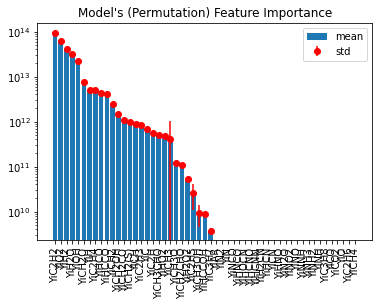

In [14]:
n_repeats = 5 if debug_mode else 20
inspector.plot_permutation_feature_importance(n_repeats=n_repeats)

            YiCH4           YiH           YiO          YiO2          YiOH  \
min  8.784053e-19  2.131450e-11  7.219606e-13  2.814459e-07  6.362021e-14   
25%  5.823258e-05  2.314374e-06  3.506846e-08  9.786150e-04  1.064949e-06   
50%  9.065550e-02  1.563337e-04  2.228664e-05  1.692361e-02  7.273621e-04   
75%  4.376321e-01  1.326813e-03  1.303170e-02  1.533269e-01  2.896765e-02   
max  9.933906e-01  3.582605e-03  4.114710e-02  9.815920e-01  7.381304e-02   

        YiH2O         YiHO2        YiH2O2           YiC          YiCH  ...  \
min  0.002418  5.531009e-11  1.000665e-11  8.919199e-22  5.736710e-34  ...   
25%  0.154099  2.526883e-07  3.566752e-08  1.151650e-12  6.640500e-13  ...   
50%  0.251930  9.812720e-06  1.159154e-06  2.241509e-09  4.426664e-09  ...   
75%  0.328292  6.406310e-05  2.702663e-06  3.203632e-06  4.562364e-06  ...   
max  0.379232  6.498796e-04  3.658455e-05  2.604863e-04  2.321344e-04  ...   

           YiHCNO        YiHOCN        YiHNCO         YiNCO        Y

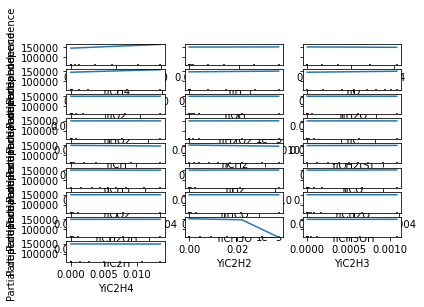

In [15]:
inspector.plot_partial_dependence()

### Print & Record Linear Embeddings Output

In [13]:
import numpy as np

def inspect_PCA(X):
    PCA_dict = {}
    PCA_dict['X'] = X
    PCA_dict['Var'] = PCA_dict['X'].var(axis=0)
    
    # sort by explained variance
    sort_idx = np.argsort(PCA_dict['Var'])[::-1]
    PCA_dict['X'] = PCA_dict['X'][:, sort_idx]
    PCA_dict['Var'] = PCA_dict['Var'][sort_idx]
    PCA_dict['CumVar'] = np.add.accumulate(PCA_dict['Var'])
    return PCA_dict


X, Y, rom, zmix = dm.getAllData()
FullDataset = inspect_PCA(X)
try:    
    linearAutoEncoder = exprExec.modelFactory.getLinearEncoder()
    X = linearAutoEncoder.predict(FullDataset['X'])
    DNN_PCA = inspect_PCA(X)
except KeyError:
    print('No Linear Auto Encoder!')

Model: "linear_embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
linear_embedding (Dense)     (None, 2)                 108       
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________


train_set_keys:  [25034, 15777, 32353, 23782, 2134, 7694, 3217, 9944, 7309, 4849, 21463, 11018, 14989, 10467, 3386, 20390, 5373, 9446, 3949, 3564, 18402, 6944, 30735, 12208, 3752, 14239, 2620]
test_set_keys:  [2758, 2246, 3056, 2364, 13527, 2027, 4376, 2903, 5104, 8974, 16608, 12851, 5656, 6267, 8099, 27738, 4157, 17482, 2489, 5953, 8525, 11598, 19371, 29198, 6597, 26352, 22593, 4606]
train:  [ 3752 11018 12208  3217  2620]
test:  [ 2903 27738  2758 12851 17482]
[0.10568778 0.05694787]
[0.22440106 0.06827898]


Text(0.5, 1.0, 'PCA Total Variance Comparison')

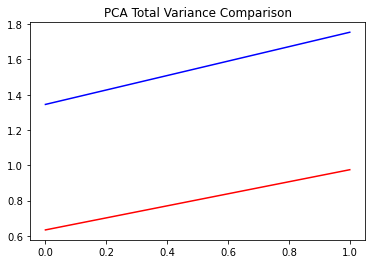

In [15]:
#dm.createDataset
import matplotlib.pyplot as plt
import copy
dm_PurePCA = copy.deepcopy(dm)
dm_PurePCA.createTrainTestData(dataSetMethod='PurePCA_randomequalflamesplit',
                               numCpvComponents=2, ipscaler=None, opscaler=None)

X,Y,rom,zmix = dm_PurePCA.getAllData()
PurePCA = inspect_PCA(X)
print(PurePCA['Var'])
print(DNN_PCA['Var'])

plt.plot(PurePCA['CumVar']/FullDataset['Var'].sum(), color='r')
plt.plot(DNN_PCA['CumVar']/FullDataset['Var'].sum(), color='b')
plt.title('PCA Total Variance Comparison')